In [1]:
import gym

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam, lr_scheduler

from TicTacToe import TicTacToe, plot_test_game
from agents import RandomAgent, TabQAgent, DQNAgent

random.seed(0)
np.random.seed(0)

# Часть первая: крестики-нолики при помощи Q-обучения

## Q-learning

In [4]:
def step(env, player):
    action = player.choose_action(env)
    _, reward, done, _ = env.step(action)
    return reward, done

def play_episode(env, agent_cross, agent_zeros):
    done = False
    env.reset()
    agents = [agent_cross, agent_zeros]
    turn = 0
    while not done:
        reward, done = step(env, agents[turn])
        turn = 1 - turn
    
    assert reward >= -1, reward
    agent_cross.learn(reward)
    agent_zeros.learn(-reward)
    return reward
        
def train(env, agent_cross, agent_zeros, num_episodes=10_000):
    agent_cross.is_eval = False
    agent_zeros.is_eval = False
    rewards = []
    for _ in range(num_episodes):
        agent_cross.reset()
        agent_zeros.reset()
        reward = play_episode(env, agent_cross, agent_zeros)
        rewards.append(reward)
    env.close()
    return np.mean(rewards)

def validate(env, agent, n_episodes=1_000, crosses=True):
    agent.is_eval = True

    if crosses == True:
        agents = [agent, RandomAgent()]
    else:    
        agents = [RandomAgent(), agent]

    rewards = []  
    for _ in range(n_episodes):
        env.reset()
        done = False
        turn = 0
        while not done:
            action = agents[turn].choose_action(env)
            _, cur_reward, done, _ = env.step(action)
            turn = 1 - turn
        rewards.append(cur_reward)
    
    return np.mean(rewards)

In [5]:
def q_learning(n_iter, step_size=100):    
    env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
        
    agent_cross = TabQAgent(N_ROWS * N_COLS, ALPHA, GAMMA, EPS)
    agent_zeros = TabQAgent(N_ROWS * N_COLS, ALPHA, GAMMA, EPS)
   
    mean_cross_reward = []
    mean_zeros_reward = []
    iters = []
    for i in tqdm(range(n_iter)):
        train(env, agent_cross, agent_zeros, step_size)
        mean_cross_reward.append(validate(env, agent_cross, n_episodes=step_size, crosses=True))
        mean_zeros_reward.append(validate(env, agent_zeros, n_episodes=step_size, crosses=False))
        iters.append((i + 1) * step_size)
        
    figure(figsize=(12, 8))
    plt.plot(iters, mean_cross_reward, label='cross rewards')    
    plt.plot(iters, -1 * np.array(mean_zeros_reward), label='zeros rewards')    
    plt.legend()
    plt.title(f'Board {N_ROWS} x {N_COLS}', fontsize=20)
    plt.xlabel('iteration', fontsize=20)
    plt.ylabel('mean reward', fontsize=20)
    plt.grid(True)
    plt.show()

100%|██████████| 500/500 [01:53<00:00,  4.39it/s]


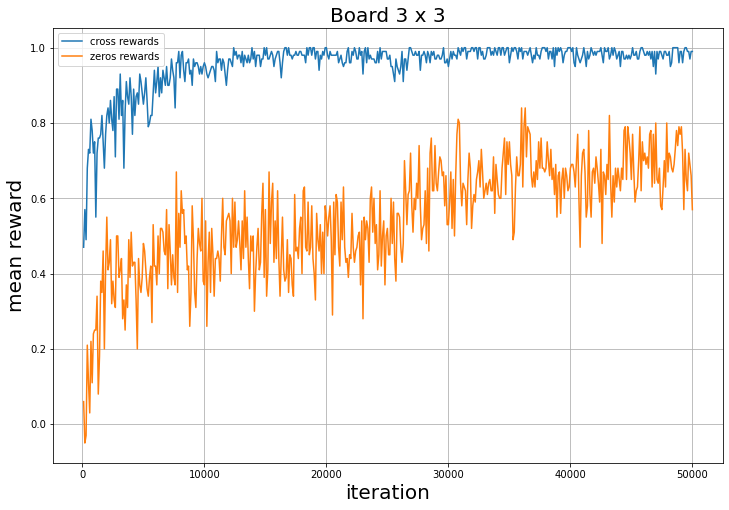

In [6]:
N_COLS, N_ROWS, N_WIN = 3, 3, 3
ALPHA, GAMMA, EPS = 0.01, 0.7, 0.3

q_learning(500)

100%|██████████| 3000/3000 [24:37<00:00,  2.03it/s]


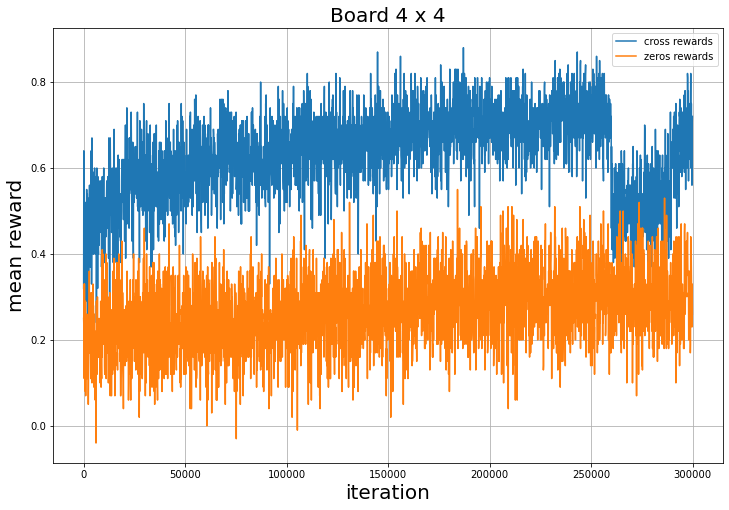

In [4]:
N_COLS, N_ROWS, N_WIN = 4, 4, 4
ALPHA, GAMMA, EPS = 0.01, 0.7, 0.3

q_learning(3_000)

С помощью Q-learning удалось хорошо обучить только крестики. В целом результаты для доски 3x3 получились лучше, чем для 4x4. Несмотря на то, что обучение для 4x4 длилось существенно дольше, приблизиться к 3x3 не получилось. 5x5 не стала пробовать из-за увеличения времени обучения.

# Часть вторая: добавим нейронных сетей

## DQN

In [5]:
class DuelingQModel(nn.Module):
    def __init__(self, hid_size, game_size, action_size):
        super().__init__()
        self.hid_size = hid_size
        self.conv = nn.Conv2d(in_channels=1, out_channels=hid_size, kernel_size=game_size)
        self.fc1 = nn.Linear(hid_size, hid_size)
        self.fc_adv = nn.Linear(hid_size, action_size)
        self.fc_val = nn.Linear(hid_size, 1)

    def forward(self, state):
        x = self.conv(state).view(-1, self.hid_size)
        x = self.fc1(x)
        x = F.relu(x)
        adv = self.fc_adv(x)
        val = self.fc_val(x)
        return val + (adv - adv.mean())
    
class QModel(nn.Module):
    def __init__(self, hid_size, game_size, action_size):
        super().__init__()    
        self.hid_size = hid_size
        self.conv_layer = nn.Conv2d(1, out_channels=hid_size, kernel_size=game_size)
        self.fc1 = nn.Linear(hid_size, hid_size)
        self.fc2 = nn.Linear(hid_size, action_size)

    def forward(self, state):
        x = self.conv_layer(state).view(-1, self.hid_size)
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc2(x)       
    
def step(env, player):
    action = player.choose_action(env)
    _, reward, done, _ = env.step(action)
    return reward, done

def run_episode(env, agent_cross, agent_zeros, train_cross=True, train_zeros=True):
    done = False
    env.reset()
    agents = [agent_cross, agent_zeros]
    turn = 0
    while not done:
        reward, done = step(env, agents[turn])
        turn = 1 - turn
    
    agent_cross.consume(reward)
    agent_zeros.consume(-reward)
    if train_cross:
        agent_cross.train_step()
    if train_zeros:
        agent_zeros.train_step()
    return reward

def train(env, agent_cross, agent_zeros, num_episodes=10 ** 2, train_cross=True, train_zeros=True):
    agent_cross.is_eval = False
    agent_zeros.is_eval = False
    rewards = []
    for _ in range(num_episodes):
        reward = run_episode(env, agent_cross, agent_zeros, train_cross, train_zeros)
        rewards.append(reward)
    env.close()
    return np.mean(rewards)

def validate(env, agent, n_episodes=1_000, crosses=True):
    agent.is_eval = True

    if crosses == True:
        agents = [agent, RandomAgent()]
    else:    
        agents = [RandomAgent(), agent]

    rewards = []  
    for _ in range(n_episodes):
        env.reset()
        done = False
        turn = 0
        while not done:
            action = agents[turn].choose_action(env)
            _, cur_reward, done, _ = env.step(action)
            turn = 1 - turn
        rewards.append(cur_reward)
    
    return np.mean(rewards)

In [6]:
def train_dqn(model, init_steps=100, num_iter=100, game_size=3, step_size=100):
    env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
       
    agent_cross = DQNAgent(model, HID_SIZE, game_size, N_ROWS * N_COLS, BUFFER_SIZE,
                           BATCH_SIZE, GAMMA, LEARNING_RATE, EPS)
    agent_zeros = DQNAgent(model, HID_SIZE, game_size, N_ROWS * N_COLS, BUFFER_SIZE,
                           BATCH_SIZE, GAMMA, LEARNING_RATE, EPS)
    random_player = RandomAgent()
    
    mean_cross_reward = []
    mean_zeros_reward = []
    iters = []
        
    for _ in range(init_steps):
        run_episode(env, agent_cross, agent_zeros, train_cross=False, train_zeros=False)
    
    for i in tqdm(range(num_iter)):
        train(env, agent_cross, agent_zeros, step_size, train_cross=True, train_zeros=True)
        mean_cross_reward.append(validate(env, agent_cross, n_episodes=step_size, crosses=True))
        mean_zeros_reward.append(validate(env, agent_zeros, n_episodes=step_size, crosses=False))
        iters.append((i + 1) * step_size)
                                
    figure(figsize=(12, 8))
    plt.plot(iters, mean_cross_reward, label='cross rewards')    
    plt.plot(iters, -1 * np.array(mean_zeros_reward), label='zeros rewards')    
    plt.legend()
    plt.title(f'Board {N_ROWS} x {N_COLS}', fontsize=20)
    plt.xlabel('iteration', fontsize=20)
    plt.ylabel('mean reward', fontsize=20)
    plt.grid(True)
    plt.show()

## DQN board 3x3

100%|██████████| 300/300 [11:27<00:00,  2.29s/it]


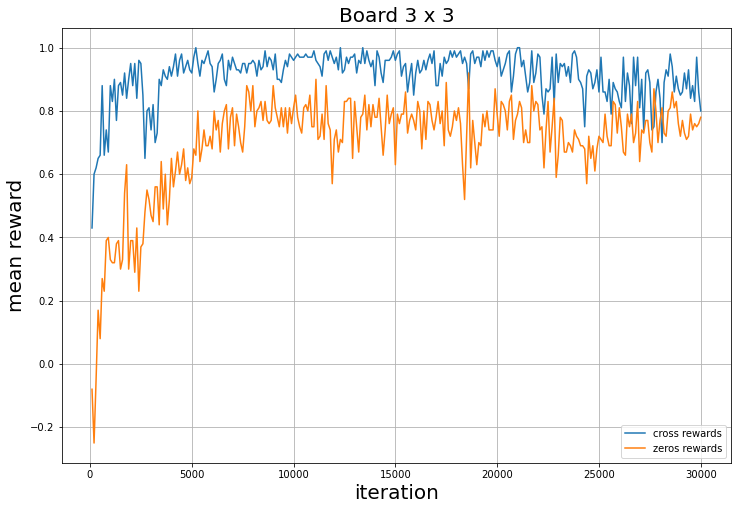

In [7]:
BATCH_SIZE, HID_SIZE, INITIAL_STEPS = 256, 256, 256
BUFFER_SIZE = 10_000
LEARNING_RATE = 1e-5
EPS = .5
GAMMA = .9

N_COLS, N_ROWS, N_WIN = 3, 3, 3

train_dqn(QModel, init_steps=256, num_iter=300, game_size=3)

## DQN board 4x4

100%|██████████| 300/300 [14:21<00:00,  2.87s/it]


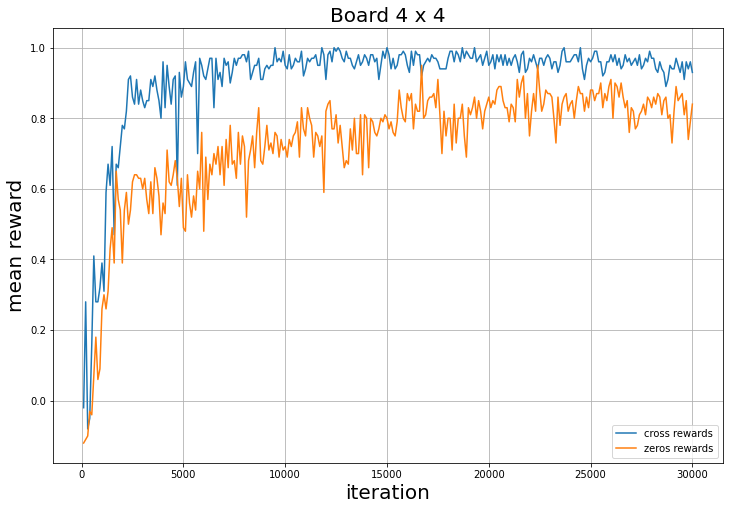

In [8]:
BATCH_SIZE, HID_SIZE, INITIAL_STEPS = 256, 256, 256
BUFFER_SIZE = 10_000
LEARNING_RATE = 1e-5
EPS = .5
GAMMA = .9

N_COLS, N_ROWS, N_WIN = 4, 4, 4

train_dqn(QModel, init_steps=256, num_iter=300, game_size=4)

## Dueling DQN board 3x3

100%|██████████| 300/300 [13:00<00:00,  2.60s/it]


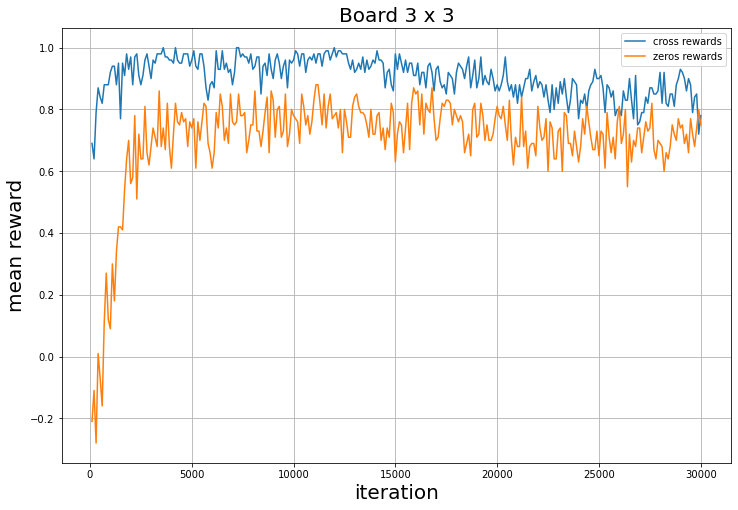

In [9]:
BATCH_SIZE, HID_SIZE, INITIAL_STEPS = 256, 256, 256
BUFFER_SIZE = 10_000
LEARNING_RATE = 1e-5
EPS = .5
GAMMA = .9

N_COLS, N_ROWS, N_WIN = 3, 3, 3
train_dqn(DuelingQModel, init_steps=256, num_iter=300, game_size=3)

## Dueling DQN board 4x4

100%|██████████| 300/300 [16:14<00:00,  3.25s/it]


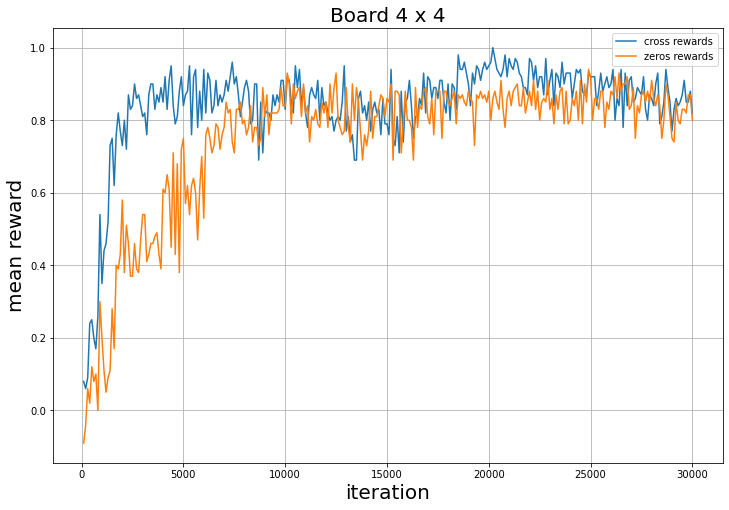

In [10]:
BATCH_SIZE, HID_SIZE, INITIAL_STEPS = 256, 256, 256
BUFFER_SIZE = 10_000
LEARNING_RATE = 1e-5
EPS = .5
GAMMA = .9

N_COLS, N_ROWS, N_WIN = 4, 4, 4
train_dqn(DuelingQModel, init_steps=256, num_iter=300, game_size=4)

Применение DQN помогло улучшить результаты для ноликов. Обе реализации показали себя хорошо, но до идеальных статегий довести не удалось. Возможно, увеличение итераций помогло бы получить результаты получше.  